# Начальная конфигурация

In [1]:
import os
from dotenv import load_dotenv
import json
import warnings
from pathlib import Path
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional, Callable, cast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import umap

In [2]:
load_dotenv()
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
def get_env_str(var, default):
    return os.getenv(var, default)


def get_env_int(var, default):
    try:
        return int(os.getenv(var, default))
    except (TypeError, ValueError):
        return default


def get_env_float(var, default):
    try:
        return float(os.getenv(var, default))
    except (TypeError, ValueError):
        return default


def get_env_bool(var, default):
    val = os.getenv(var)
    if val is None:
        return default
    return val.lower() in ("1", "true", "yes", "on")


@dataclass
class PathConfig:
    base_dir: str = field(default_factory=lambda: get_env_str('BASE_DIR', 'yandex_music_dataset'))
    audio_dir: str = field(default_factory=lambda: get_env_str('AUDIO_DIR', 'audio_files'))
    metadata_file: str = field(default_factory=lambda: get_env_str('METADATA_FILE', 'metadata.json'))
    features_cache: str = field(default_factory=lambda: get_env_str('FEATURES_CACHE', 'features_cache.npz'))
    tensorboard_dir: str = field(default_factory=lambda: get_env_str('TENSORBOARD_DIR', 'runs/genre_classification'))

    @property
    def audio_path(self) -> Path:
        return Path(self.base_dir) / self.audio_dir

    @property
    def metadata_path(self) -> Path:
        return Path(self.base_dir) / self.metadata_file

    @property
    def cache_path(self) -> Path:
        return Path(self.base_dir) / self.features_cache

In [4]:
@dataclass
class AudioConfig:
    sample_rate: int = field(default_factory=lambda: get_env_int('SAMPLE_RATE', 22050))
    duration_seconds: float = field(default_factory=lambda: get_env_float('DURATION_SECONDS', 30.0))
    n_mfcc: int = field(default_factory=lambda: get_env_int('N_MFCC', 40))
    n_fft: int = field(default_factory=lambda: get_env_int('N_FFT', 2048))
    hop_length: int = field(default_factory=lambda: get_env_int('HOP_LENGTH', 512))
    n_mels: int = field(default_factory=lambda: get_env_int('N_MELS', 128))

    @property
    def max_samples(self) -> int:
        return int(self.sample_rate * self.duration_seconds)

In [5]:
@dataclass
class ModelConfig:
    hidden_size: int = field(default_factory=lambda: get_env_int('HIDDEN_SIZE', 64))
    num_layers: int = field(default_factory=lambda: get_env_int('NUM_LAYERS', 1))
    dropout: float = field(default_factory=lambda: get_env_float('DROPOUT', 0.5))
    bidirectional: bool = field(default_factory=lambda: get_env_bool('BIDIRECTIONAL', True))
    # Более устойчивый пуллинг по времени: mean | last
    pooling: str = field(default_factory=lambda: get_env_str('POOLING', 'mean'))
    # Нормализация pooled-вектора
    layer_norm: bool = field(default_factory=lambda: get_env_bool('LAYER_NORM', True))

In [6]:
@dataclass
class TrainingConfig:
    batch_size: int = field(default_factory=lambda: get_env_int('BATCH_SIZE', 16))
    learning_rate: float = field(default_factory=lambda: get_env_float('LEARNING_RATE', 0.0003))
    num_epochs: int = field(default_factory=lambda: get_env_int('NUM_EPOCHS', 50))
    early_stopping_patience: int = field(default_factory=lambda: get_env_int('EARLY_STOPPING_PATIENCE', 10))
    # Чувствительность к улучшению
    early_stopping_min_delta: float = field(default_factory=lambda: get_env_float('EARLY_STOPPING_MIN_DELTA', 0.01))
    test_size: float = field(default_factory=lambda: get_env_float('TEST_SIZE', 0.2))
    val_size: float = field(default_factory=lambda: get_env_float('VAL_SIZE', 0.15))
    random_state: int = field(default_factory=lambda: get_env_int('RANDOM_STATE', 42))
    weight_decay: float = field(default_factory=lambda: get_env_float('WEIGHT_DECAY', 5e-4))

    # Повышение устойчивости
    label_smoothing: float = field(default_factory=lambda: get_env_float('LABEL_SMOOTHING', 0.1))
    max_grad_norm: float = field(default_factory=lambda: get_env_float('MAX_GRAD_NORM', 1.0))

    # Параметры аугментации MFCC (SpecAugment-подобной)
    augment_prob: float = field(default_factory=lambda: get_env_float('AUGMENT_PROB', 0.8))
    time_mask_param: int = field(default_factory=lambda: get_env_int('TIME_MASK_PARAM', 30))
    freq_mask_param: int = field(default_factory=lambda: get_env_int('FREQ_MASK_PARAM', 12))
    num_time_masks: int = field(default_factory=lambda: get_env_int('NUM_TIME_MASKS', 3))
    num_freq_masks: int = field(default_factory=lambda: get_env_int('NUM_FREQ_MASKS', 3))

    # Доп. аугментация: случайный сдвиг по времени (в кадрах MFCC)
    max_time_shift_frames: int = field(default_factory=lambda: get_env_int('MAX_TIME_SHIFT_FRAMES', 40))

    # Параметры шедулера
    scheduler_patience: int = field(default_factory=lambda: get_env_int('SCHEDULER_PATIENCE', 2))
    scheduler_factor: float = field(default_factory=lambda: get_env_float('SCHEDULER_FACTOR', 0.5))

In [7]:

def get_genres_from_env() -> list:
    return [g.strip() for g in os.getenv('GENRES_TO_COLLECT', '').split(',') if g.strip()]


def set_global_seed(seed: int, cuda: bool) -> None:
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda and torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


@dataclass
class Config:
    paths: PathConfig = field(default_factory=PathConfig)
    audio: AudioConfig = field(default_factory=AudioConfig)
    model: ModelConfig = field(default_factory=ModelConfig)
    training: TrainingConfig = field(default_factory=TrainingConfig)
    genres: List[str] = field(default_factory=get_genres_from_env)
    device: str = field(default_factory=lambda: "cuda" if torch.cuda.is_available() else "cpu")


config = Config()
set_global_seed(config.training.random_state, cuda=(config.device == "cuda"))
print(f"Device: {config.device}")
print(f"Genres: {config.genres}")

Device: cpu
Genres: ['rock', 'jazz', 'hiphop']


## Загрузка и анализ метаданных

In [8]:

def load_metadata(config: Config) -> pd.DataFrame:
    # JSON
    with open(config.paths.metadata_path, 'r', encoding='utf-8') as f:
        metadata = json.load(f)

    df = pd.DataFrame(metadata['tracks'])
    df = df[df['downloaded_success'] == True]
    return df


metadata_df = load_metadata(config)
print(f"Всего треков: {len(metadata_df)}")
metadata_df.head()

Всего треков: 150


,original_id,filename,file_path,artist,title,genre,downloaded_success
0,58548079,ИГРА МИРОВ - Рок.mp3,yandex_music_dataset/audio_files/ИГРА МИРОВ - ...,ИГРА МИРОВ,Рок,rock,True
1,558,Black Eyed Peas - Rock That Body.mp3,yandex_music_dataset/audio_files/Black Eyed Pe...,Black Eyed Peas,Rock That Body,rock,True
2,103247532,BUSHIDO ZHO - Rock.mp3,yandex_music_dataset/audio_files/BUSHIDO ZHO -...,BUSHIDO ZHO,Rock,rock,True
3,1710811,Queen - We Will Rock You.mp3,yandex_music_dataset/audio_files/Queen - We Wi...,Queen,We Will Rock You,rock,True
4,53497069,Radek - Rock Bottom.mp3,yandex_music_dataset/audio_files/Radek - Rock ...,Radek,Rock Bottom,rock,True


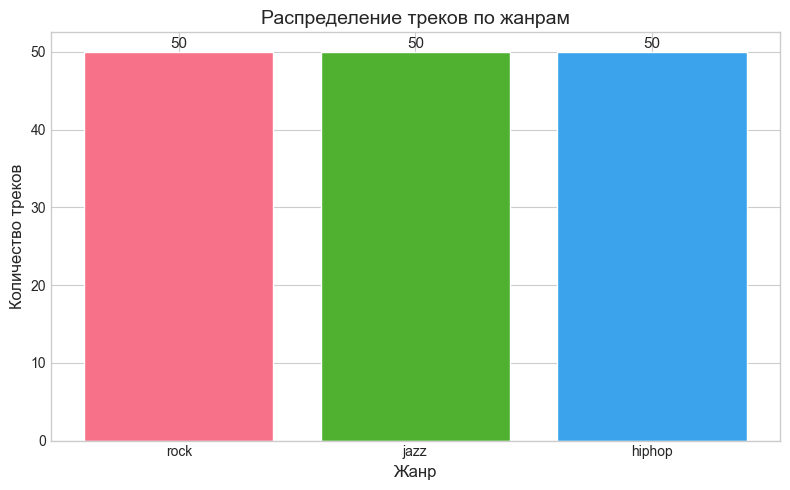

In [9]:

def plot_genre_distribution(df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(figsize=(8, 5))
    genre_counts = df['genre'].value_counts()

    colors = sns.color_palette("husl", len(genre_counts))
    bars = ax.bar(genre_counts.index, genre_counts.values, color=colors)

    ax.set_xlabel('Жанр', fontsize=12)
    ax.set_ylabel('Количество треков', fontsize=12)
    ax.set_title('Распределение треков по жанрам', fontsize=14)

    for bar, count in zip(bars, genre_counts.values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                str(count), ha='center', fontsize=11)

    plt.tight_layout()
    plt.show()


plot_genre_distribution(metadata_df)

## Извлечение аудио-признаков (MFCC)

In [10]:

def load_audio(file_path: str, config: Config) -> Optional[np.ndarray]:
    """Загрузка аудиофайла с нормализацией"""
    try:
        audio, sr = librosa.load(
            file_path,
            sr=config.audio.sample_rate,
            duration=config.audio.duration_seconds
        )
        # Паддинг/обрезка длины аудиофайлов
        if len(audio) < config.audio.max_samples:
            audio = np.pad(audio, (0, config.audio.max_samples - len(audio)))
        else:
            audio = audio[:config.audio.max_samples]
        return audio
    except Exception as e:
        print(f"Ошибка загрузки {file_path}: {e}")
        return None

In [11]:

def extract_mfcc(audio: np.ndarray, config: Config) -> np.ndarray:
    mfcc = librosa.feature.mfcc(
        y=audio,
        sr=config.audio.sample_rate,
        n_mfcc=config.audio.n_mfcc,
        n_fft=config.audio.n_fft,
        hop_length=config.audio.hop_length
    )

    # Нормализация sample-wise
    mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-8)
    return mfcc.T

In [12]:

def extract_features_batch(
        df: pd.DataFrame,
        config: Config
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    features_list = []
    labels_list = []
    valid_files = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Извлечение признаков"):
        file_path = str(row['file_path'])
        audio = load_audio(file_path, config)
        if audio is None:
            continue

        mfcc = extract_mfcc(audio, config)
        features_list.append(mfcc)
        labels_list.append(row['genre'])
        valid_files.append(row['filename'])

    return np.array(features_list), np.array(labels_list), valid_files

In [13]:

def load_or_extract_features(
        df: pd.DataFrame,
        config: Config
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """Загрузка признаков из кэша или их извлечение"""
    cache_path = config.paths.cache_path

    if cache_path.exists():
        data = np.load(cache_path, allow_pickle=True)
        return data['features'], data['labels'], data['files'].tolist()

    features, labels, files = extract_features_batch(df, config)

    # Сохранение в кэш
    np.savez(cache_path, features=features, labels=labels, files=np.array(files))
    print(f"Признаки сохранены в {cache_path}")

    return features, labels, files


features, labels, filenames = load_or_extract_features(metadata_df, config)
print(f"Форма признаков: {features.shape}")
print(f"Количество меток: {len(labels)}")

Форма признаков: (150, 1292, 40)
Количество меток: 150


## Визуализация аудио-признаков

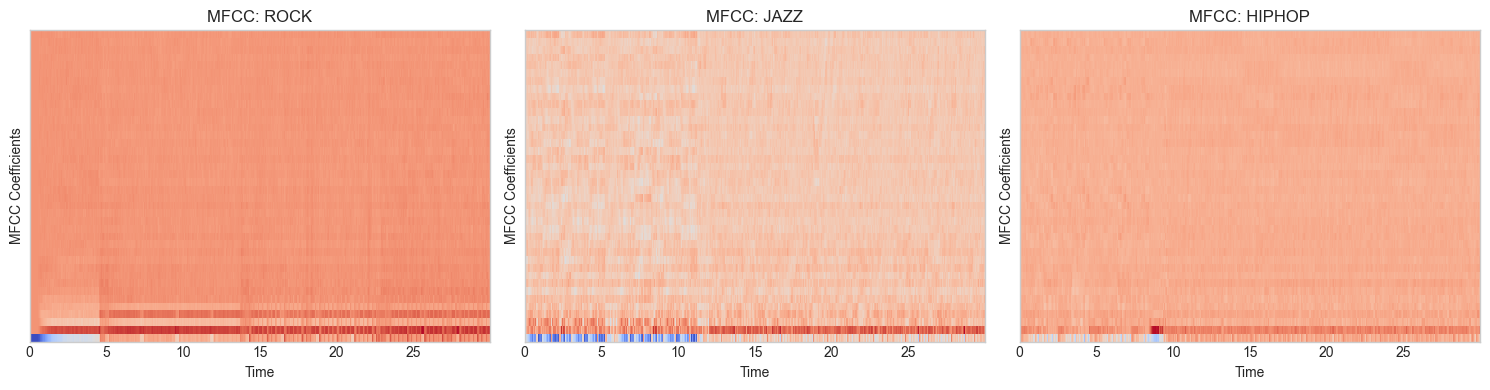

In [14]:

def plot_mfcc_comparison(features: np.ndarray, labels: np.ndarray, config: Config) -> None:
    """Визуализация MFCC для каждого жанра"""

    genres_to_show = config.genres if config.genres else list(pd.unique(labels))[:3]
    fig, axes = plt.subplots(1, len(genres_to_show), figsize=(15, 4))

    for idx, genre in enumerate(genres_to_show):
        genre_indices = np.where(labels == genre)[0]
        if len(genre_indices) == 0:
            axes[idx].set_title(f'Нет примеров: {genre}')
            axes[idx].axis('off')
            continue
        mfcc = features[genre_indices[0]].T

        img = librosa.display.specshow(
            mfcc,
            x_axis='time',
            sr=config.audio.sample_rate,
            hop_length=config.audio.hop_length,
            ax=axes[idx]
        )
        axes[idx].set_title(f'MFCC: {genre.upper()}')
        axes[idx].set_ylabel('MFCC Coefficients')

    plt.tight_layout()
    plt.show()


plot_mfcc_comparison(features, labels, config)

## Подготовка данных для PyTorch

In [15]:
# Простая SpecAugment-подобная аугментация на MFCC для train-данных
DefAugment = Callable[[torch.Tensor], torch.Tensor]


def time_shift(mfcc: torch.Tensor, max_shift_frames: int) -> torch.Tensor:
    """Случайный циклический сдвиг по времени (ось 0) на уровне MFCC"""

    if max_shift_frames <= 0:
        return mfcc
    T = mfcc.shape[0]
    if T <= 1:
        return mfcc
    shift = int(torch.randint(low=-max_shift_frames, high=max_shift_frames + 1, size=(1,)).item())
    if shift == 0:
        return mfcc
    return torch.roll(mfcc, shifts=shift, dims=0)


def spec_augment(mfcc: torch.Tensor, *, time_mask_param: int, freq_mask_param: int,
                 num_time_masks: int, num_freq_masks: int, p: float) -> torch.Tensor:
    """
    - mfcc: Tensor [T, F]
    - Применяет случайные маски по времени и частоте с вероятностью p
    """
    if p <= 0.0 or torch.rand(1).item() > p:
        return mfcc
    T, F = mfcc.shape
    out = mfcc.clone()

    # Time masks
    for _ in range(max(0, num_time_masks)):
        t = int(torch.randint(low=0, high=max(1, time_mask_param + 1), size=(1,)).item())
        t0 = int(torch.randint(low=0, high=max(1, T - t + 1), size=(1,)).item()) if T - t + 1 > 0 else 0
        if t > 0:
            out[t0:t0 + t, :] = 0

    # Freq masks
    for _ in range(max(0, num_freq_masks)):
        f = int(torch.randint(low=0, high=max(1, freq_mask_param + 1), size=(1,)).item())
        f0 = int(torch.randint(low=0, high=max(1, F - f + 1), size=(1,)).item()) if F - f + 1 > 0 else 0
        if f > 0:
            out[:, f0:f0 + f] = 0
    return out


class AudioDataset(Dataset):

    def __init__(self, features: np.ndarray, labels: np.ndarray, transform: Optional[Callable[[torch.Tensor], torch.Tensor]] = None):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.features[idx]
        if self.transform is not None:
            x = self.transform(x)
        return x, self.labels[idx]

In [16]:

def prepare_data_loaders(
        features: np.ndarray,
        labels: np.ndarray,
        config: Config
) -> Tuple[DataLoader, DataLoader, DataLoader, LabelEncoder]:
    """Подготовка DataLoader'ов для train/val/test"""

    # Кодирование меток
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    # Разбиение на train/temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        features, encoded_labels,
        test_size=config.training.test_size + config.training.val_size,
        random_state=config.training.random_state,
        stratify=encoded_labels
    )

    # Разбиение temp на val/test
    val_ratio = config.training.val_size / (config.training.test_size + config.training.val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=1 - val_ratio,
        random_state=config.training.random_state,
        stratify=y_temp
    )

    # Трансформ только для train
    train_transform: Optional[Callable[[torch.Tensor], torch.Tensor]] = (
        lambda x: spec_augment(
            time_shift(x, config.training.max_time_shift_frames),
            time_mask_param=config.training.time_mask_param,
            freq_mask_param=config.training.freq_mask_param,
            num_time_masks=config.training.num_time_masks,
            num_freq_masks=config.training.num_freq_masks,
            p=config.training.augment_prob,
        )
    )

    train_dataset = AudioDataset(X_train, y_train, transform=train_transform)
    val_dataset = AudioDataset(X_val, y_val, transform=None)
    test_dataset = AudioDataset(X_test, y_test, transform=None)

    train_loader = DataLoader(train_dataset, batch_size=config.training.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.training.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.training.batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, label_encoder

In [17]:

train_loader, val_loader, test_loader, label_encoder = prepare_data_loaders(features, labels, config)

# Явные ссылки на конкретный тип датасета для статического анализатора
train_ds: AudioDataset = cast(AudioDataset, train_loader.dataset)
val_ds: AudioDataset = cast(AudioDataset, val_loader.dataset)
test_ds: AudioDataset = cast(AudioDataset, test_loader.dataset)

print(f"Train samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")
print(f"Classes: {label_encoder.classes_}")

Train samples: 97
Validation samples: 22
Test samples: 31
Classes: ['hiphop' 'jazz' 'rock']


## Определение модели (LSTM)

In [18]:

class GenreClassifierLSTM(nn.Module):

    def __init__(self, input_size: int, num_classes: int, config: ModelConfig):
        super().__init__()
        self.config = config

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=config.hidden_size,
            num_layers=config.num_layers,
            batch_first=True,
            dropout=config.dropout if config.num_layers > 1 else 0,
            bidirectional=config.bidirectional
        )

        lstm_output_size = config.hidden_size * (2 if config.bidirectional else 1)

        # Нормализация pooled-вектора перед классификатором
        self.layer_norm = nn.LayerNorm(lstm_output_size) if config.layer_norm else None

        self.classifier = nn.Sequential(
            nn.Dropout(config.dropout),
            nn.Linear(lstm_output_size, 64),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(64, num_classes)
        )

    def _pool(self, lstm_out: torch.Tensor, hidden: torch.Tensor) -> torch.Tensor:

        if self.config.pooling.lower() == 'mean':
            return lstm_out.mean(dim=1)

        if self.config.bidirectional:
            return torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            return hidden[-1]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        lstm_out, (hidden, _) = self.lstm(x)
        pooled = self._pool(lstm_out, hidden)
        if self.layer_norm is not None:
            pooled = self.layer_norm(pooled)
        return self.classifier(pooled)

    def get_embedding(self, x: torch.Tensor) -> torch.Tensor:
        lstm_out, (hidden, _) = self.lstm(x)
        pooled = self._pool(lstm_out, hidden)
        if self.layer_norm is not None:
            pooled = self.layer_norm(pooled)

        # Все слои кроме последнего
        for layer in list(self.classifier.children())[:-1]:
            pooled = layer(pooled)
        return pooled


input_size = config.audio.n_mfcc
num_classes = int(len(np.unique(labels)))

model = GenreClassifierLSTM(input_size, num_classes, config.model)
model = model.to(config.device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

GenreClassifierLSTM(
  (lstm): LSTM(40, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

Total parameters: 586,499


## Обучение модели с TensorBoard

In [19]:

class EarlyStopping:
    """Early Stopping для предотвращения переобучения: учитывает порог улучшения"""

    def __init__(self, patience: int = 10, min_delta: float = 0.005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False

    def __call__(self, val_loss: float) -> bool:
        if self.best_loss is None:
            self.best_loss = val_loss
            self.counter = 0
            return False
        if val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.should_stop

In [20]:

def train_epoch(
        model: nn.Module,
        loader: DataLoader,
        criterion: nn.Module,
        optimizer: optim.Optimizer,
        device: str,
        max_grad_norm: float
) -> Tuple[float, float]:

    """Одна эпоха обучения"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for features, labels in loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()

        # Градиентный клиппинг для стабильности RNN
        if max_grad_norm and max_grad_norm > 0:
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return total_loss / len(loader), correct / total

In [21]:
@torch.no_grad()

def evaluate(
        model: nn.Module,
        loader: DataLoader,
        criterion: nn.Module,
        device: str
) -> Tuple[float, float]:

    """Оценка модели на валидации/тесте"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for features, labels in loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return total_loss / len(loader), correct / total

In [22]:

def train_model(
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        config: Config
) -> Dict[str, List[float]]:

    """Полный цикл обучения модели"""
    # Балансировка классов по train-части
    with torch.no_grad():
        train_ds_local: AudioDataset = cast(AudioDataset, train_loader.dataset)
        train_labels_tensor = train_ds_local.labels
        num_classes_local = int(torch.max(train_labels_tensor).item() + 1)
        class_counts = torch.bincount(train_labels_tensor, minlength=num_classes_local).float()
        class_weights = (train_labels_tensor.numel() / (num_classes_local * class_counts.clamp(min=1)))
        class_weights = class_weights.to(config.device)

    try:
        criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=float(config.training.label_smoothing))
    except TypeError:
        criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.Adam(
        model.parameters(),
        lr=config.training.learning_rate,
        weight_decay=config.training.weight_decay
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=config.training.scheduler_patience,
        factor=config.training.scheduler_factor
    )
    early_stopping = EarlyStopping(patience=config.training.early_stopping_patience,
                                   min_delta=config.training.early_stopping_min_delta)

    writer = SummaryWriter(config.paths.tensorboard_dir)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Лучшие веса по val_loss
    best_val_loss = float('inf')
    best_state = None

    for epoch in range(config.training.num_epochs):
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, config.device, config.training.max_grad_norm
        )
        val_loss, val_acc = evaluate(model, val_loader, criterion, config.device)

        # Обновление лучших весов при заметном улучшении
        if val_loss < best_val_loss - config.training.early_stopping_min_delta:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{config.training.num_epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if early_stopping(val_loss):
            print(f"Early stopping at epoch {epoch + 1} (patience={early_stopping.patience}, min_delta={early_stopping.min_delta})")
            break

    writer.close()

    # Восстановление лучших весов перед оценкой/сохранением
    if best_state is not None:
        model.load_state_dict(best_state)

    return history

In [23]:

history = train_model(model, train_loader, val_loader, config)

Epoch 5/80 | Train Loss: 1.0102 | Train Acc: 0.5155 | Val Loss: 1.0205 | Val Acc: 0.5909
Epoch 10/80 | Train Loss: 1.1098 | Train Acc: 0.5258 | Val Loss: 0.9846 | Val Acc: 0.5455
Epoch 15/80 | Train Loss: 0.8690 | Train Acc: 0.6392 | Val Loss: 1.0307 | Val Acc: 0.5455
Early stopping at epoch 17 (patience=10, min_delta=0.01)


## Визуализация обучения

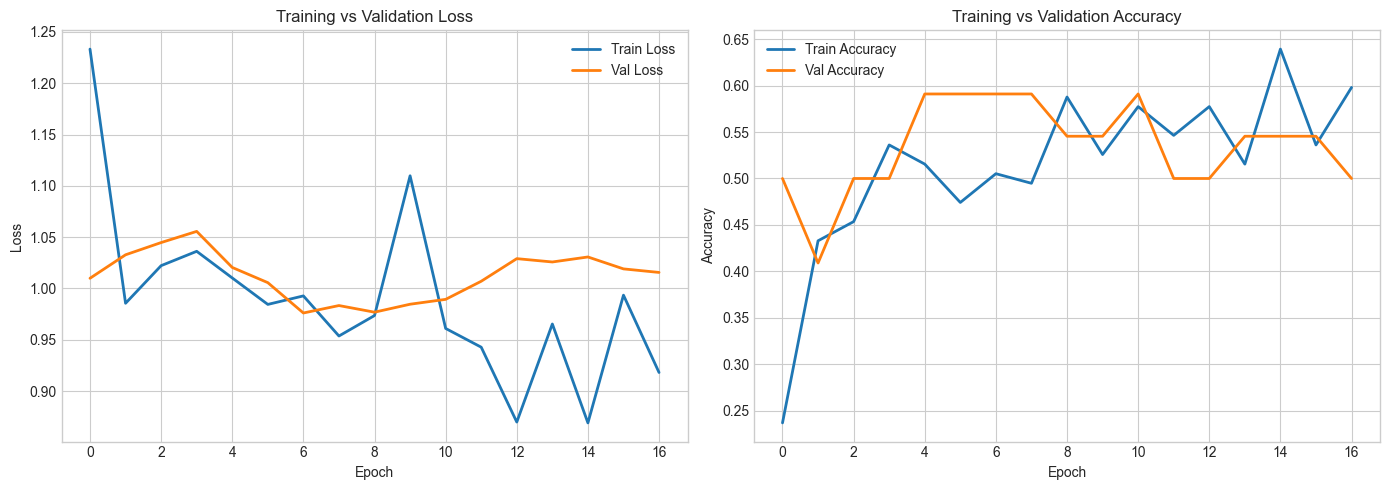


Анализ переобучения:
Final Train Accuracy: 0.5979
Final Val Accuracy: 0.5000
Gap: 0.0979


In [24]:

def plot_training_history(history: Dict[str, List[float]]) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training vs Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy
    axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history['val_acc'], label='Val Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training vs Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    if history['train_acc'] and history['val_acc']:
        final_train_acc = history['train_acc'][-1]
        final_val_acc = history['val_acc'][-1]
        gap = final_train_acc - final_val_acc

        print(f"\nАнализ переобучения:")
        print(f"Final Train Accuracy: {final_train_acc:.4f}")
        print(f"Final Val Accuracy: {final_val_acc:.4f}")
        print(f"Gap: {gap:.4f}")

plot_training_history(history)

# Оценка на тестовой выборке

In [25]:
@torch.no_grad()

def get_predictions(
        model: nn.Module,
        loader: DataLoader,
        device: str
) -> Tuple[np.ndarray, np.ndarray]:
    """Предсказания модели"""

    model.eval()
    all_preds = []
    all_labels = []

    for features, labels in loader:
        features = features.to(device)
        outputs = model(features)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

In [26]:

def plot_confusion_matrix(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        classes: List[str]
) -> None:
    """Матрица ошибок"""

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [27]:

test_preds, test_labels = get_predictions(model, test_loader, config.device)

print("Classification Report (Test Set)")
print("-" * 65)
print(classification_report(test_labels, test_preds, target_names=label_encoder.classes_))

test_accuracy = accuracy_score(test_labels, test_preds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

Classification Report (Test Set)
-----------------------------------------------------------------
              precision    recall  f1-score   support

      hiphop       0.14      0.10      0.12        10
        jazz       0.47      0.73      0.57        11
        rock       0.71      0.50      0.59        10

    accuracy                           0.45        31
   macro avg       0.44      0.44      0.43        31
weighted avg       0.44      0.45      0.43        31


Test Accuracy: 0.4516


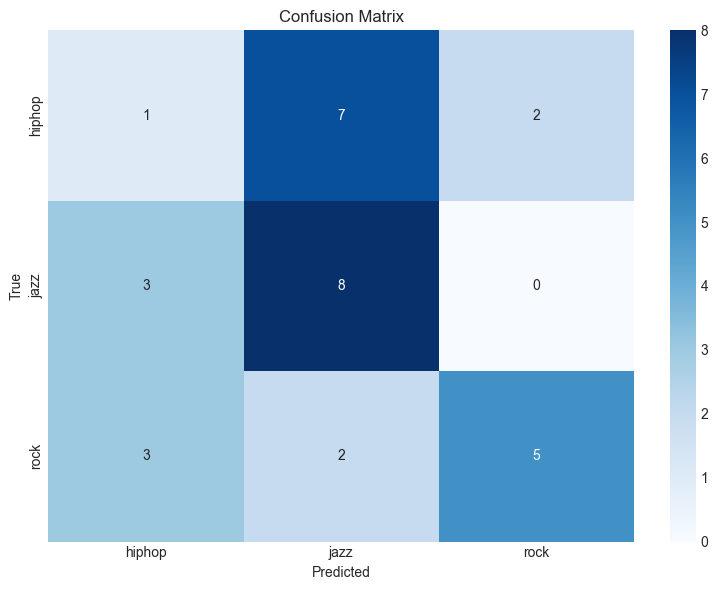

In [28]:
plot_confusion_matrix(test_labels, test_preds, label_encoder.classes_.tolist())

## Создание и визуализация эмбеддингов

In [29]:
@torch.no_grad()

def extract_embeddings(
        model: nn.Module,
        features: np.ndarray,
        device: str,
        batch_size: int = 32
) -> np.ndarray:
    """Извлечение эмбеддингов из предпоследнего слоя модели"""

    model.eval()
    embeddings = []

    for i in range(0, len(features), batch_size):
        batch = torch.FloatTensor(features[i:i + batch_size]).to(device)
        emb = model.get_embedding(batch)
        embeddings.append(emb.cpu().numpy())

    return np.vstack(embeddings)

In [30]:

def plot_embeddings_2d(
        embeddings: np.ndarray,
        labels: np.ndarray,
        label_encoder: LabelEncoder
) -> None:
    """Визуализация эмбеддингов в 2D с помощью UMAP"""

    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embeddings_2d = reducer.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))

    encoded_labels = label_encoder.transform(labels)
    classes = label_encoder.classes_
    colors = sns.color_palette("husl", len(classes))

    for idx, genre in enumerate(classes):
        mask = encoded_labels == idx
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=[colors[idx]],
            label=genre.upper(),
            alpha=0.7,
            s=100
        )

    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title('Audio Embeddings Visualization (UMAP)')
    plt.legend(title='Genre', loc='best')
    plt.tight_layout()
    plt.show()

Форма эмбеддингов: (150, 64)


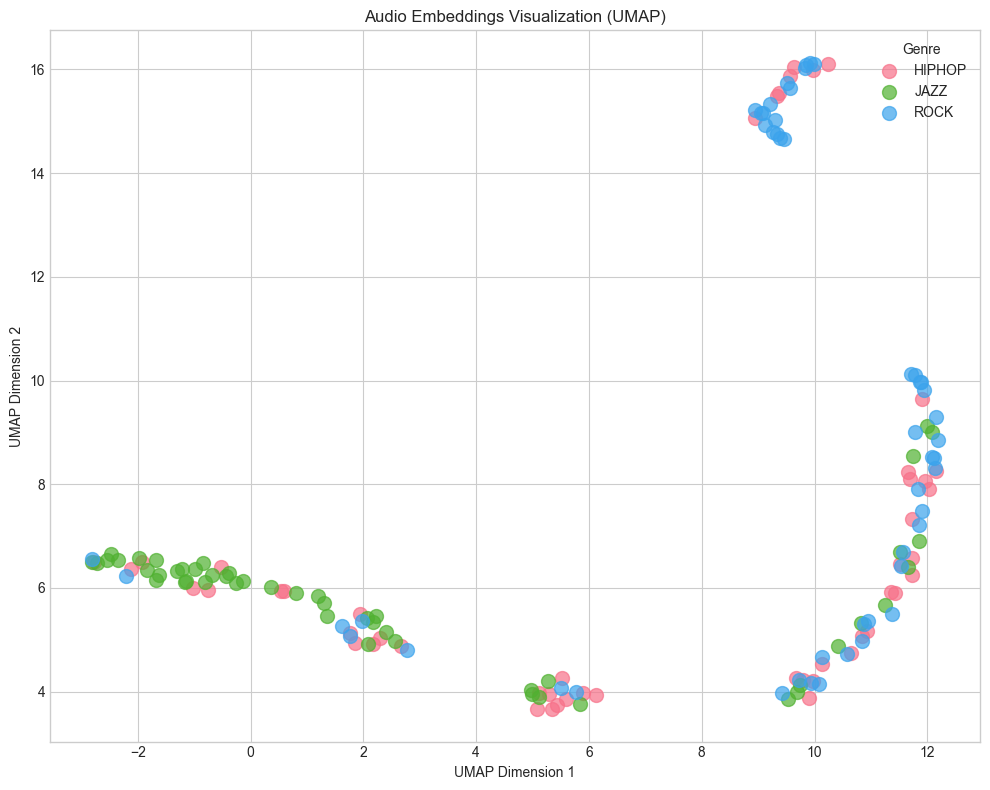

In [31]:
# Извлечение эмбеддингов для всего датасета
embeddings = extract_embeddings(model, features, config.device)
print(f"Форма эмбеддингов: {embeddings.shape}")

plot_embeddings_2d(embeddings, labels, label_encoder)

### Сохранение модели и метаданных

In [32]:

def save_model(
        model: nn.Module,
        label_encoder: LabelEncoder,
        config: Config,
        path: str = "genre_classifier.pth"
) -> None:

    checkpoint = {
        'model_state_dict': model.state_dict(),
        'label_encoder_classes': label_encoder.classes_.tolist(),
        'config': {
            'input_size': config.audio.n_mfcc,
            'num_classes': len(np.unique(labels)),
            'model_config': config.model.__dict__
        }
    }
    torch.save(checkpoint, path)
    print(f"Модель сохранена в {path}")


save_model(model, label_encoder, config)

Модель сохранена в genre_classifier.pth


### Демонстрация предсказания на примере

In [33]:
@torch.no_grad()
def predict_genre(
        model: nn.Module,
        audio_path: str,
        config: Config,
        label_encoder: LabelEncoder
) -> Tuple[Optional[str], Optional[Dict[str, float]]]:
    model.eval()

    predicted_genre: Optional[str] = None
    prob_dict: Optional[Dict[str, float]] = None

    audio = load_audio(audio_path, config)
    if audio is not None:
        mfcc = extract_mfcc(audio, config)
        features = torch.FloatTensor(mfcc).unsqueeze(0).to(config.device)
        outputs = model(features)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted_idx = probabilities.argmax()
        predicted_genre = label_encoder.inverse_transform([predicted_idx])[0]
        prob_dict = {genre: float(prob) for genre, prob in zip(label_encoder.classes_, probabilities)}

    return predicted_genre, prob_dict

In [34]:

sample_file = metadata_df.sample(1, random_state=config.training.random_state).iloc[0]
print(f"Файл: {sample_file['filename']}")
print(f"Истинный жанр: {sample_file['genre']}")

predicted_genre, probabilities = predict_genre(
    model, str(sample_file['file_path']), config, label_encoder
)

print(f"\nПредсказанный жанр: {predicted_genre}")
print("\nВероятности:")
if probabilities is not None:
    for genre, prob in sorted(probabilities.items(), key=lambda x: -x[1]):
        print(f"  {genre}: {prob:.4f}")

Файл: Jazz Evening - Smooth Lounge Jazz for Relaxation. Джаз Музыка для Отдыха и Фона.mp3
Истинный жанр: jazz

Предсказанный жанр: jazz

Вероятности:
  jazz: 0.4209
  hiphop: 0.3494
  rock: 0.2297


# Итог

In [35]:
print(f"\nДатасет:")
print(f"   Всего треков: {len(features)}")
print(f"   Жанры: {', '.join(config.genres) if config.genres else ', '.join(list(map(str, np.unique(labels))))}")
print(f"   Треков на жанр: ~{len(features) // max(1, int(len(np.unique(labels))))}")

print(f"\nАудио параметры:")
print(f"   Sample rate: {config.audio.sample_rate} Hz")
print(f"   Длительность: {config.audio.duration_seconds} сек")
print(f"   MFCC коэффициентов: {config.audio.n_mfcc}")

print(f"\nМодель:")
print(f"   Тип: Bidirectional LSTM")
print(f"   Hidden size: {config.model.hidden_size}")
print(f"   Num layers: {config.model.num_layers}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nРезультаты:")
if history['train_acc'] and history['val_acc']:
    print(f"   Train Accuracy: {history['train_acc'][-1]:.4f}")
    print(f"   Val Accuracy: {history['val_acc'][-1]:.4f}")
else:
    print("   История обучения пустая или не завершена")
print(f"   Test Accuracy: {test_accuracy:.4f}")

if history['train_acc'] and history['val_acc']:
    gap = history['train_acc'][-1] - history['val_acc'][-1]
    print(f"\ngap = {gap:.4f}")


Датасет:
   Всего треков: 150
   Жанры: rock, jazz, hiphop
   Треков на жанр: ~50

Аудио параметры:
   Sample rate: 22050 Hz
   Длительность: 30.0 сек
   MFCC коэффициентов: 40

Модель:
   Тип: Bidirectional LSTM
   Hidden size: 128
   Num layers: 2
   Parameters: 586,499

Результаты:
   Train Accuracy: 0.5979
   Val Accuracy: 0.5000
   Test Accuracy: 0.4516

gap = 0.0979
